# Analysis of Trucks for Sale using TRD as a search term

In [1]:
import pandas as pd
import sqlite3
from os.path import expanduser
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
%matplotlib inline

In [2]:
db = '/Volumes/craigslist/craigslist.db'
db = expanduser('~/Documents/Craiglist/craigslist.db')
conn = sqlite3.connect(db)
c = conn.cursor()
c.execute('pragma table_info(trdValues);')
cols = ', '.join([r[1] for r in c.fetchall()])

dat = pd.read_sql('select %s from trdvalues where accessdate = (select max(accessdate) from trdvalues) group by %s;' % (cols, cols)
                  , conn)

city = pd.read_sql('select * from sites;', conn)

conn.close()


###Setting up functions to classify the data

In [3]:
def CateOwnerDealer(d):
    if 'cto' in d:
        return 'Owner'
    elif 'ctd' in d:
        return 'Dealer'

def Vehicle(txt):
    if txt == None: txt = ''
    if 'tacoma' in txt.lower():
        return 'Tacoma'
    elif 'tundra' in txt.lower():
        return 'Tundra'

def GetYear(txt):
    if txt == None: txt = ''
    txt = txt.strip()
    txt = ' %s ' % txt
    year = re.search(' (20\d\d) ', txt)
    if year:
        return int(year.group(1))
    year = re.search(' (19\d\d) ', txt)
    if year:
        return int(year.group(1))
    
def getCity(txt):
    return txt[7:txt.index('.cra')]

def determineSalvage(row):
    for key in 'condition body title'.split(' '):
        if not row[key]:
            row[key] = ''
    return 'salvage' in row['condition'].lower() or 'salvage' in row['body'].lower() or 'salvage' in row['title'].lower()
    
def getSiteURL(txt):
    return txt[ 5 : txt.index('craigslist.org') + 15]
    

In [4]:
dat['CityURL'] = dat.url.apply(getSiteURL)
city = city.rename(columns = {'url': 'CityURL'})
dat = pd.merge(dat, city, on = 'CityURL', how = 'left')

In [5]:
dat['seller'] = dat.url.apply(CateOwnerDealer)

dat['vehicle'] = dat.title.apply(Vehicle)


dat['year'] = dat.title.apply(GetYear)
dat.loc[ dat['year'].isnull(), 'year'] = dat.loc[ dat['year'].isnull() , 'body'].apply(GetYear)

dat['salvage'] = dat.apply(lambda row: determineSalvage(row), axis = 1)

In [6]:
dat.describe()



,lat,lon,price,accessDate,postDate,year,salvage
count,3241.000000,3241.000000,8398.000000,9698.000000,9.698000e+03,9226.000000,9698
mean,37.135648,-103.907376,18728.909621,20160122.000000,2.015756e+11,2008.011272,0.01154877
std,6.480485,21.259501,12086.255905,0.229782,4.023911e+07,4.926900,0.1068484
min,19.508900,-159.530300,1.000000,20160122.000000,2.015112e+11,1970.000000,False
25%,33.675000,-121.356290,9999.000000,20160122.000000,2.015123e+11,2005.000000,0
50%,37.306600,-105.096200,17400.000000,20160122.000000,2.016011e+11,2008.000000,0
75%,40.874200,-83.126000,26412.500000,20160122.000000,2.016012e+11,2012.000000,0
max,64.828300,-67.600800,360000.000000,20160122.000000,2.016012e+11,2016.000000,True


##Linear Regession without the state variable
*normalized the year variable by taking mean*


In [7]:
clean = dat.loc[dat.salvage == False, ['year',  'odometer', 'seller', 'vehicle', 'price',
                                       'drive', 'transmission']].fillna(np.nan).dropna()

clean[['price', 'odometer', 'year']] = clean[['price', 'odometer', 'year']].astype(int)
clean = clean.loc[(clean.price >= 5000) &(clean.odometer >= 10000) & (clean.odometer <= 400000) &
                  (clean.price <= 40000), ]


clean.year = clean.year - clean.year.mean()


clean = pd.merge(clean[['price', 'odometer', 'year']],
         pd.get_dummies(clean[['seller', 'vehicle', 'drive']]),
         how = 'left', left_index = True, right_index = True)

X = sm.add_constant(clean.loc[:,[name for name in clean.columns if name != 'price']])

mod = sm.OLS(clean.price, X).fit()
mod.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     3025.
Date:                Sun, 24 Jan 2016   Prob (F-statistic):               0.00
Time:                        15:29:13   Log-Likelihood:                -29220.
No. Observations:                3085   AIC:                         5.845e+04
Df Residuals:                    3078   BIC:                         5.850e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const           1.109e+04     98.666    112.397      0.000      1.09e+04  1.13e+04
odometer          -0.0549      0.002    -34.768      0.000        -0.058    -0.052
year            1099.0470     22.580     48.673      0.000      1054.773  1143.321
seller_Dealer   6154.1551     76.269     80.691      0.000      6004.613  6303.698
seller_Owner    4935.6653     76.345     64.649      0.000      4785.973  5085.358
vehicle_Tacoma  5102.5675     72.773     70.116      0.000      4959.879  5245.256
vehicle_Tundra  5987.2530     84.554     70.810      0.000      5821.465  6153.041
drive_4wd       5546.6252    146.272     37.920      0.000      5259.825  5833.425
drive_fwd       2717.8911    335.721      8.096      0.000      2059.631  3376.151
drive_rwd       2825.3041    156.224     18.085      0.000      2518.990  3131.618
==============================================================================
Omnibus:                      160.704   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              501.607
Skew:                           0.199   Prob(JB):                    1.20e-109
Kurtosis:                       4.935   Cond. No.                     1.08e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.48e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [8]:
parms = pd.DataFrame(mod.params).rename(columns = {0:'Coef'})
parms.loc[[c for c in parms.index if 'state' in c],].sort('Coef').\
    apply(lambda row: '{:20,.2f}'.format(row['Coef']), axis = 1 )
parms

,Coef
const,11089.820426
odometer,-0.054892
year,1099.047035
seller_Dealer,6154.155106
seller_Owner,4935.665320
vehicle_Tacoma,5102.567466
vehicle_Tundra,5987.252960
drive_4wd,5546.625232
drive_fwd,2717.891142
drive_rwd,2825.304052


###Top 40 Cheapest 4WD Tacomas in States Near Me


In [9]:
errors = pd.merge(pd.DataFrame(mod.resid), dat, 
         how = 'left', left_index= True, right_index=True).rename(columns = {0:'error'}).sort('error')

states = ['Arizona', 'Nevada', 'California', 'Colorado', 'Kansas', 'Missouri', 'Montana', 'Nebraska', 'New Mexico', 
          'North Carolina', 'Oklahoma', 'Tennessee', 'Texas', 'Virginia', 'Wyoming', 'Utah']

errors.loc[(errors.drive == '4wd') & (errors.vehicle == 'Tacoma') & errors.state.isin(states), 
           ['title', 'url', 'price']].head(40)


,title,url,price
2422,\n2009TOYOTA TACOMA TRD\n\n,http://lasvegas.craigslist.org/cto/5412273901....,9500
4805,\nToyota Tacoma 2010\n\n,http://inlandempire.craigslist.org/cto/5398140...,12000
4196,2012 Toyota Tacoma TRD SPORT 4X4 Manual,http://nashville.craigslist.org/ctd/5382252221...,19897
2003,\n2013 TOYOTA TACOMA TRD 4X4!\n\n,http://chattanooga.craigslist.org/ctd/54087127...,21450
8691,\n2013 Toyota Tacoma 4x4 Access Cab w/ TRD Mil...,http://sandiego.craigslist.org/csd/ctd/5383259...,23999
8692,\n2013 Toyota Tacoma 4x4 Access Cab w/ TRD Mil...,http://sandiego.craigslist.org/csd/ctd/5413560...,23999
3764,\n2002 Toyota Tacoma TRD\n\n,http://denver.craigslist.org/cto/5391346812.html,5500
8846,\n2006 Toyota Tacoma 4x4\n\n,http://missoula.craigslist.org/cto/5403158548....,9200
7539,\n2003 Toyota Tacoma Base V6 4-Speed Automatic...,http://tulsa.craigslist.org/ctd/5397654054.html,7898
7540,\n2003 Toyota Tacoma Base V6 4-Speed Automatic...,http://tulsa.craigslist.org/ctd/5397654054.html,7898


##Linear Model Using States as a Variable


In [10]:
clean = dat.loc[dat.salvage == False, ['year',  'odometer', 'seller', 'vehicle', 'price',
                                       'drive', 'transmission', 'state']].fillna(np.nan).dropna()

clean[['price', 'odometer']] =clean[['price', 'odometer']].astype(int)
clean = clean.loc[(clean.price >= 5000) &(clean.odometer >= 10000) & (clean.odometer <= 400000) &
                  (clean.price <= 40000), ]

clean.year = clean.year - clean.year.mean()

clean = pd.merge(clean[['price', 'odometer', 'year']],
         pd.get_dummies(clean[['seller', 'vehicle', 'drive', 'state']]),
         how = 'left', left_index = True, right_index = True)
mod = sm.OLS(clean.price, clean.loc[:,[name for name in clean.columns if name != 'price']]).fit()
mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     400.7
Date:                Sun, 24 Jan 2016   Prob (F-statistic):               0.00
Time:                        15:29:14   Log-Likelihood:                -28889.
No. Observations:                3085   AIC:                         5.789e+04
Df Residuals:                    3027   BIC:                         5.824e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
odometer                      -0.0521      0.002    -34.598      0.000        -0.055    -0.049
year                        1103.2516     21.428     51.487      0.000      1061.237  1145.266
seller_Dealer               9541.5828    104.259     91.518      0.000      9337.156  9746.009
seller_Owner                8595.2587     99.936     86.007      0.000      8399.309  8791.209
vehicle_Tacoma              8385.0834     98.298     85.303      0.000      8192.346  8577.821
vehicle_Tundra              9751.7581    108.624     89.775      0.000      9538.774  9964.742
drive_4wd                   8145.0007    129.590     62.852      0.000      7890.908  8399.094
drive_fwd                   5051.3171    324.600     15.562      0.000      4414.858  5687.776
drive_rwd                   4940.5236    139.245     35.481      0.000      4667.499  5213.548
state_Alabama                218.3851    462.066      0.473      0.637      -687.610  1124.380
state_Alaska                1395.8847    484.543      2.881      0.004       445.818  2345.952
state_Arizona               2212.1648    293.449      7.538      0.000      1636.785  2787.544
state_Arkansas                48.7079    686.896      0.071      0.943     -1298.122  1395.538
state_California            2450.5940    157.348     15.574      0.000      2142.074  2759.114
state_Colorado              1652.4377    208.787      7.914      0.000      1243.060  2061.816
state_Connecticut          -2057.6160    651.395     -3.159      0.002     -3334.838  -780.394
state_Delaware              -640.8904   1402.822     -0.457      0.648     -3391.470  2109.689
state_District of Columbia  -451.2564    548.185     -0.823      0.410     -1526.109   623.596
state_Florida                885.2883    281.374      3.146      0.002       333.585  1436.992
state_Georgia               1736.4885    352.104      4.932      0.000      1046.102  2426.875
state_Hawaii                2117.7683    374.274      5.658      0.000      1383.912  2851.625
state_Idaho                 2018.0876    592.253      3.407      0.001       856.828  3179.347
state_Illinois               125.2084    604.934      0.207      0.836     -1060.915  1311.332
state_Indiana               -906.0468    849.472     -1.067      0.286     -2571.648   759.554
state_Iowa                  -299.4233    649.620     -0.461      0.645     -1573.165   974.319
state_Kansas                1436.1037    937.557      1.532      0.126      -402.209  3274.416
state_Kentucky              1062.4071    649.669      1.635      0.102      -211.429  2336.244
state_Louisiana             1024.0205    996.812      1.027      0.304      -930.477  2978.518
state_Maine                 -452.6094    559.818     -0.808      0.419     -1550.271   645.052
state_Maryland             -1212.7887   140

###Coefficents for each State


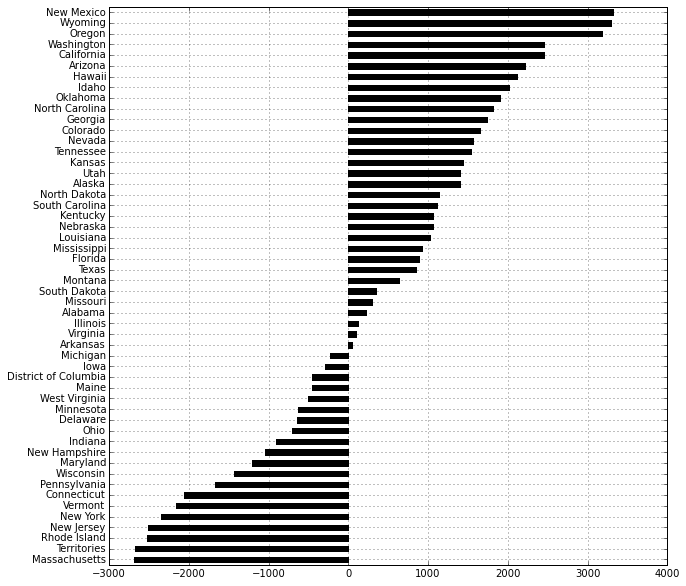

In [11]:
parms = pd.DataFrame(mod.params).rename(columns = {0:'Coef'})

states = parms.loc[[c for c in parms.index if 'state' in c],]

states.set_index(states.index.map(lambda i: i[6:])).sort('Coef').plot(kind = 'barh',  figsize=(10, 10), 
                                                                      colormap = 'gray', legend = False, grid =  True)

#parms.loc[[c for c in parms.index if 'state' in c],].sort('Coef').plot(kind = 'bar')
    #apply(lambda row: '{:20,.2f}'.format(row['Coef']), axis = 1 ).plot()


###Non State Variables

In [12]:
parms.loc[[c for c in parms.index if 'state' not in c],].sort('Coef').\
    apply(lambda row: '{:20,.2f}'.format(row['Coef']), axis = 1 )

odometer                         -0.05
year                          1,103.25
drive_rwd                     4,940.52
drive_fwd                     5,051.32
drive_4wd                     8,145.00
vehicle_Tacoma                8,385.08
seller_Owner                  8,595.26
seller_Dealer                 9,541.58
vehicle_Tundra                9,751.76
dtype: object

In [13]:
dat.to_csv('MergedData.csv', encoding = 'utf-8')